# Analysis of the Loan Default Rate

### Metadata
- LoanID: A unique identifier for each loan.
- Age: The age of the borrower.
- Income: The annual income of the borrower.
- LoanAmount: The amount of money being borrowed.
- CreditScore: The credit score of the borrower, indicating their creditworthiness.
- MonthsEmployed: The number of months the borrower has been employed.
- NumCreditLines: The number of credit lines the borrower has open.
- InterestRate: The interest rate for the loan.
- LoanTerm: The term length of the loan in months.
- DTIRatio: The Debt-to-Income ratio, indicating the borrower's debt compared to their income.
- Education: The highest level of education attained by the borrower (PhD, Master's, Bachelor's, High School).
- EmploymentType: The type of employment status of the borrower (Full-time, Part-time, Self-employed, Unemployed).
- MaritalStatus: The marital status of the borrower (Single, Married, Divorced).
- HasMortgage: Whether the borrower has a mortgage (Yes or No).
- HasDependents: Whether the borrower has dependents (Yes or No).
- LoanPurpose: The purpose of the loan (Home, Auto, Education, Business, Other).
- HasCoSigner: Whether the loan has a co-signer (Yes or No).
- Default: The binary target variable indicating whether the loan defaulted (1) or not (0).

In [1]:
# Initialize a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("loan_default_prediction").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/01 13:19:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Reading the data

In [2]:
df = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load("Loan_default.csv")\
  .coalesce(10)

## (i) Exploring the dataset

In [3]:
# Checking the data types
df.printSchema()

root
 |-- LoanID: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- MonthsEmployed: integer (nullable = true)
 |-- NumCreditLines: integer (nullable = true)
 |-- InterestRate: double (nullable = true)
 |-- LoanTerm: integer (nullable = true)
 |-- DTIRatio: double (nullable = true)
 |-- Education: string (nullable = true)
 |-- EmploymentType: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- HasMortgage: string (nullable = true)
 |-- HasDependents: string (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- HasCoSigner: string (nullable = true)
 |-- Default: integer (nullable = true)



In [4]:
# Checking the number of rows
df.count()

255347

In [5]:
# Printing the first 5 rows
df.show(5)

+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+-----------+-------+
|    LoanID|Age|Income|LoanAmount|CreditScore|MonthsEmployed|NumCreditLines|InterestRate|LoanTerm|DTIRatio|  Education|EmploymentType|MaritalStatus|HasMortgage|HasDependents|LoanPurpose|HasCoSigner|Default|
+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+-----------+-------+
|I38PQUQS96| 56| 85994|     50587|        520|            80|             4|       15.23|      36|    0.44| Bachelor's|     Full-time|     Divorced|        Yes|          Yes|      Other|        Yes|      0|
|HPSK72WA7R| 69| 50432|    124440|        458|            15|             1|        4.81|      60|    0.68|   Master's|     Full-time|      Married|         No|           N

From the first five rows we can see that there are come categorical variables which will need to be encoded.

### Encoding the categorical variables

1. Categorical variables that have two classes

In [6]:
from pyspark.sql.functions import when

# Encode 'Yes' as 1 and 'No' as 0 for HasMortgage column
df = df.withColumn('HasMortgage', when(df['HasMortgage'] == 'Yes', 1)
                                  .when(df['HasMortgage'] == 'No', 0))

# Encode 'Yes' as 1 and 'No' as 0 for HasDependents column
df = df.withColumn('HasDependents', when(df['HasDependents'] == 'Yes', 1)
                                    .when(df['HasDependents'] == 'No', 0))

# Encode 'Yes' as 1 and 'No' as 0 for HasCoSigner column
df = df.withColumn('HasCoSigner', when(df['HasCoSigner'] == 'Yes', 1)
                                  .when(df['HasCoSigner'] == 'No', 0))

In [7]:
df.show(5)

+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+-----------+-------+
|    LoanID|Age|Income|LoanAmount|CreditScore|MonthsEmployed|NumCreditLines|InterestRate|LoanTerm|DTIRatio|  Education|EmploymentType|MaritalStatus|HasMortgage|HasDependents|LoanPurpose|HasCoSigner|Default|
+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+-----------+-------+
|I38PQUQS96| 56| 85994|     50587|        520|            80|             4|       15.23|      36|    0.44| Bachelor's|     Full-time|     Divorced|          1|            1|      Other|          1|      0|
|HPSK72WA7R| 69| 50432|    124440|        458|            15|             1|        4.81|      60|    0.68|   Master's|     Full-time|      Married|          0|            

In the table above we see that the categorical columns with two classes were encoded correctly.

2. Categorical variables that have more than two classes

In [8]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

categorical_columns = ["Education", "EmploymentType", "MaritalStatus", "LoanPurpose"]

# initiate an empty list called stages to store various pipeline stages 
stages = []

for categorical_col in categorical_columns:
    stringIndexer = StringIndexer(inputCol = categorical_col, outputCol = categorical_col + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categorical_col + "classVec"])
    # string indexer for converting categorical data into numerical representations. Index is added to output column name to differentiate it from original column.
    # Onehotencoder creates binary arrays from category indices created using string indexer

    stages += [stringIndexer, encoder]

# stringindexer converts from string to number but the onehotencoder produces vectors that do not prioritize the numbers in any order

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

# list of numeric columns (without the column "Default")
numeric_columns = ["Age", "Income", "LoanAmount", "CreditScore", "MonthsEmployed", "NumCreditLines", "InterestRate", "LoanTerm", "DTIRatio", "HasMortgage", "HasDependents", "HasCoSigner"]

# combine input columns for VectorAssembler
assembler_inputs = [c + "classVec" for c in categorical_columns] + numeric_columns

# create the VectorAssembler
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# add the assembler to the stages list
stages.append(assembler)

# create and run the pipeline
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

# show the features column
df.select("features").show()


24/06/01 13:19:36 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+
|            features|
+--------------------+
|[1.0,0.0,0.0,0.0,...|
|(24,[2,6,11,12,13...|
|(24,[2,4,7,12,13,...|
|(24,[1,6,8,12,13,...|
|(24,[0,4,7,12,13,...|
|(24,[1,4,8,12,13,...|
|(24,[0,4,9,12,13,...|
|(24,[6,9,12,13,14...|
|(24,[0,5,7,10,12,...|
|[0.0,1.0,0.0,0.0,...|
|(24,[1,4,6,10,12,...|
|(24,[7,10,12,13,1...|
|(24,[2,7,12,13,14...|
|(24,[1,4,12,13,14...|
|(24,[2,3,7,9,12,1...|
|(24,[2,4,6,12,13,...|
|(24,[4,9,12,13,14...|
|(24,[2,5,11,12,13...|
|(24,[0,5,7,10,12,...|
|(24,[1,5,11,12,13...|
+--------------------+
only showing top 20 rows



### Checking for missing values

In [10]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()
# for c in df: iterates over each column name in the dataframe
# col(c).isNull(): checks if the value in the current column c is null or not
# when(col(c).isNull(), c): creates a column with the column name c if the value in that column is null otherwise, it creates a column with null values
# the count function counts the number of non-null values in the current column c

+------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+---------+--------------+-------------+-----------+-------------+-----------+-----------+-------+--------------+-----------------+-------------------+----------------------+------------------+---------------------+----------------+-------------------+--------+
|LoanID|Age|Income|LoanAmount|CreditScore|MonthsEmployed|NumCreditLines|InterestRate|LoanTerm|DTIRatio|Education|EmploymentType|MaritalStatus|HasMortgage|HasDependents|LoanPurpose|HasCoSigner|Default|EducationIndex|EducationclassVec|EmploymentTypeIndex|EmploymentTypeclassVec|MaritalStatusIndex|MaritalStatusclassVec|LoanPurposeIndex|LoanPurposeclassVec|features|
+------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+---------+--------------+-------------+-----------+-------------+-----------+-----------+-------+--------------+-----------------+-------------------+-------------------

From the resulting dataframe above we can see that there are no NaN values so we don't need to delete any rows.

### Check for unbalance in the dataset

In [11]:
# register the DataFrame as a temporary view
df.createOrReplaceTempView("loan_data")

In [12]:
print("Number of loans by default status:")
spark.sql("SELECT `Default`, COUNT(*) AS count FROM loan_data GROUP BY `Default`").show()

Number of loans by default status:


+-------+------+
|Default| count|
+-------+------+
|      1| 29653|
|      0|225694|
+-------+------+



The table above indicates that there are more loans that didn't default than those that did. We can also visualize this using Pandas library.

In [13]:
# convert df to a pandas dataframe for visualization
df_pd=df.toPandas()

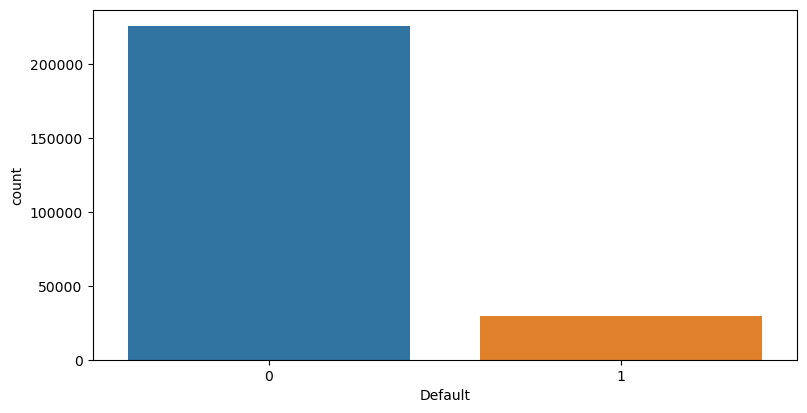

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
plt.subplot(221)
sns.countplot(x='Default', data=df_pd, order=df_pd['Default'].value_counts().index)
plt.show()

The figure above supports our previous observation that there are much more loans that didn't defaulted than those that did defaulted. This indicates that the target variable is unbalanced. This is a common issue in credit risk and fraud detection datasets, where the target class (in this case, default) is typically a rare event.

We can also use the same code to visualize distribution of other columns.

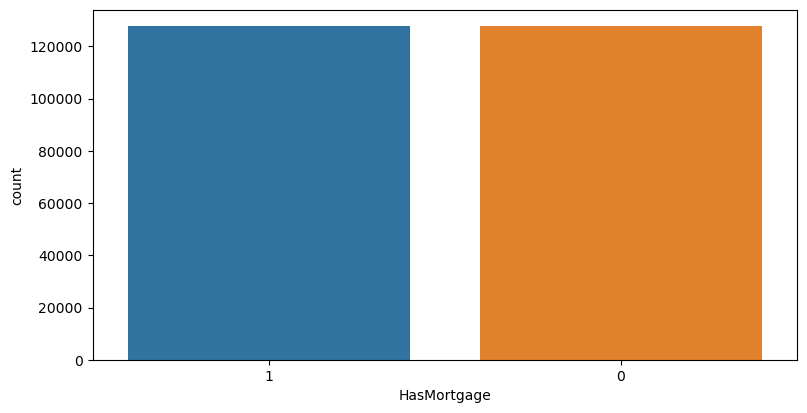

In [15]:
plt.figure(figsize=(20,10))
plt.subplot(221)
sns.countplot(x='HasMortgage', data=df_pd, order=df_pd['HasMortgage'].value_counts().index)
plt.show()

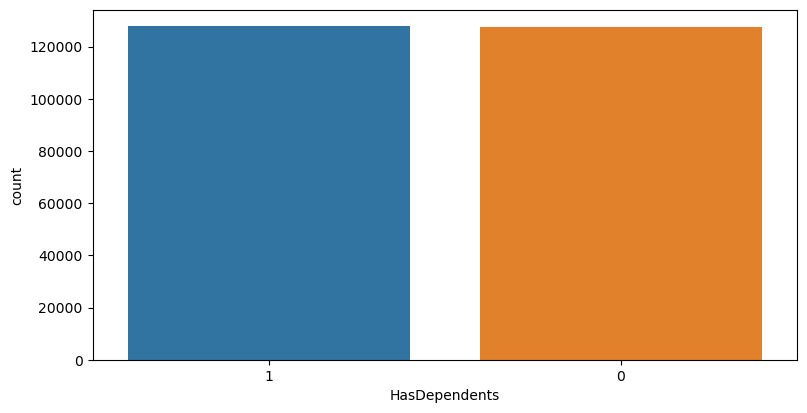

In [16]:
plt.figure(figsize=(20,10))
plt.subplot(221)
sns.countplot(x='HasDependents', data=df_pd, order=df_pd['HasDependents'].value_counts().index)
plt.show()

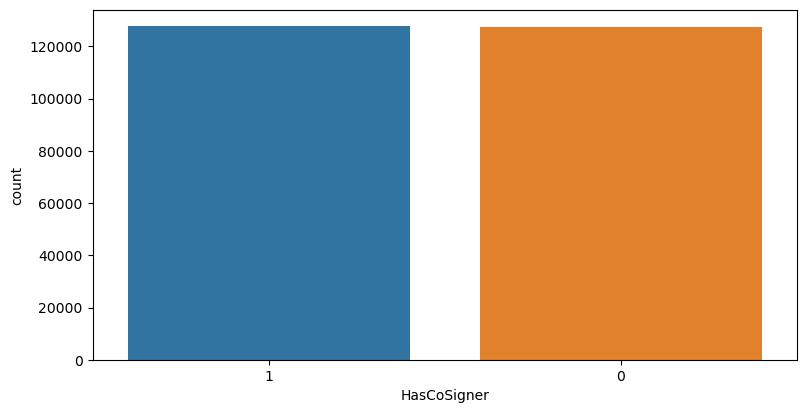

In [17]:
plt.figure(figsize=(20,10))
plt.subplot(221)
sns.countplot(x='HasCoSigner', data=df_pd, order=df_pd['HasCoSigner'].value_counts().index)
plt.show()

From the three plots above we can see that the varaibles "HasMortgage", "HasDependents", and "HasCoSigner" are perfectly equally distributed.

### Grouping data

1. Default rate by education

In [18]:
spark.sql("""
SELECT Education, ROUND(AVG(CAST(`Default` AS DOUBLE)), 2) AS default_rate
FROM loan_data
GROUP BY Education
ORDER BY default_rate DESC
""").show()

+-----------+------------+
|  Education|default_rate|
+-----------+------------+
|High School|        0.13|
| Bachelor's|        0.12|
|        PhD|        0.11|
|   Master's|        0.11|
+-----------+------------+



In the table above a higher default rate for a particular education level indicates that borrowers with that education level are more likely to default on their loans. Therefore, borrowers with high school are more likely to default than those with a Bachelor's degree and even more likely than those with either PhD or Master's degree. However, the differences among the education groups are very small.

2. Default are by income

We can also greate income classess and see how that affects the default rate. Here we take into acccount that the minimum annual income in this dataset is 15 000 and the maximum is 149 999. 

In [19]:
spark.sql("""
SELECT
    CASE
        WHEN Income < 30000 THEN 'Low Income'
        WHEN Income >= 30000 AND Income < 75000 THEN 'Middle Income'
        WHEN Income >= 75000 AND Income < 125000 THEN 'High Income'
        ELSE 'Very High Income'
    END AS income_range,
    ROUND(AVG(CAST(`Default` AS DOUBLE)), 2) AS default_rate
FROM loan_data
GROUP BY income_range
ORDER BY default_rate DESC
""").show()

+----------------+------------+
|    income_range|default_rate|
+----------------+------------+
|      Low Income|        0.22|
|   Middle Income|        0.12|
|     High Income|         0.1|
|Very High Income|        0.09|
+----------------+------------+



From the output above we see that the default rate is the highest for low income and the lowest for high and very high income. This is expected since people with low income are more likely to encounter financial trouble when paying back a loan.

3. Default rate by employment type 

In [20]:
spark.sql("""
SELECT EmploymentType, ROUND(AVG(CAST(`Default` AS DOUBLE)), 2) AS default_rate
FROM loan_data
GROUP BY EmploymentType
ORDER BY default_rate DESC
""").show()

+--------------+------------+
|EmploymentType|default_rate|
+--------------+------------+
|    Unemployed|        0.14|
|     Part-time|        0.12|
| Self-employed|        0.11|
|     Full-time|        0.09|
+--------------+------------+



As expected, the default rate is the highest for those that are unemployed and the lowest for those who are employed full-time. However, the differences between the groups are very small.

4. Default rate by loan purpose

In [21]:
spark.sql("""
SELECT LoanPurpose, ROUND(AVG(CAST(`Default` AS DOUBLE)), 2) AS default_rate
FROM loan_data
GROUP BY LoanPurpose
ORDER BY default_rate DESC
""").show()

+-----------+------------+
|LoanPurpose|default_rate|
+-----------+------------+
|  Education|        0.12|
|      Other|        0.12|
|       Auto|        0.12|
|   Business|        0.12|
|       Home|         0.1|
+-----------+------------+



Here we see that the default rate for education, auto, business,and other is the same (12%) and a little higher than for home (10%). This indicates that landing money for the purpose of home-related expenses is more safe for institutions like banks than for other loan purposes.

5. Default rate by marital status

In [22]:
spark.sql("""
SELECT MaritalStatus, ROUND(AVG(CAST(`Default` AS DOUBLE)), 2) AS default_rate
FROM loan_data
GROUP BY MaritalStatus
ORDER BY default_rate DESC
""").show()

+-------------+------------+
|MaritalStatus|default_rate|
+-------------+------------+
|     Divorced|        0.13|
|       Single|        0.12|
|      Married|         0.1|
+-------------+------------+



We see that those that are divorced have a higher default rate than those that are single and married.

### Checking for outliers

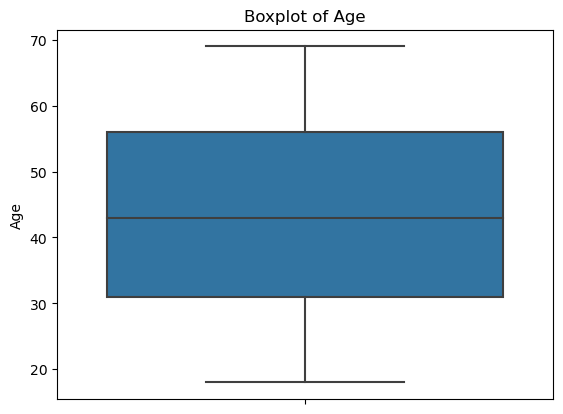

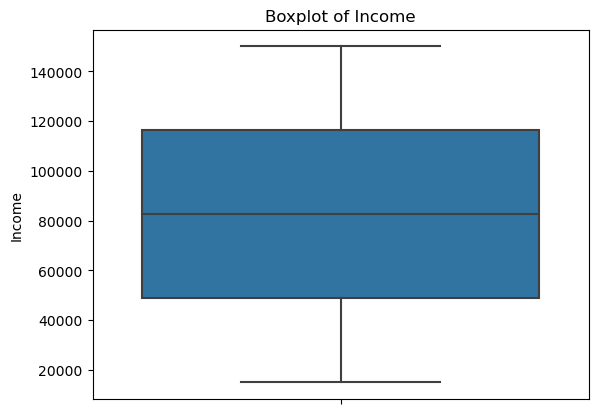

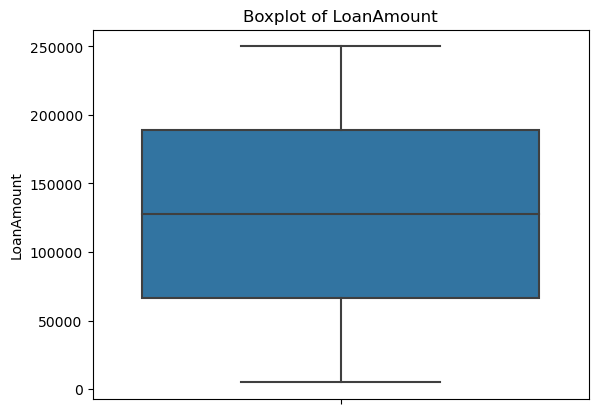

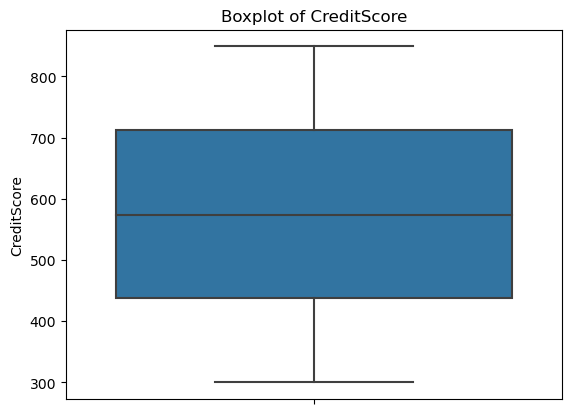

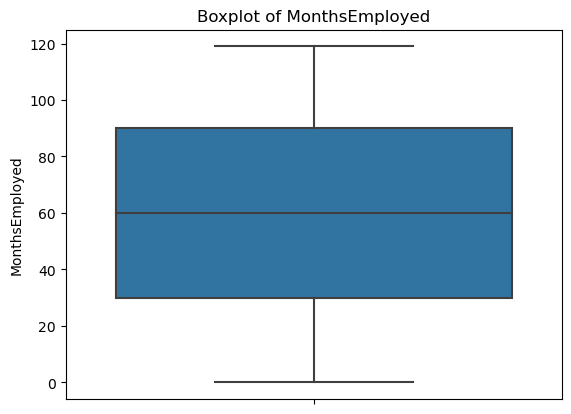

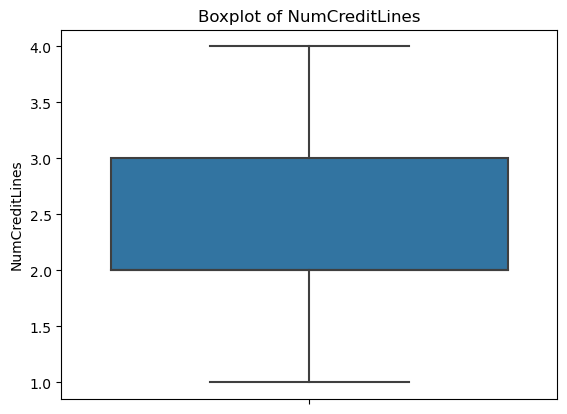

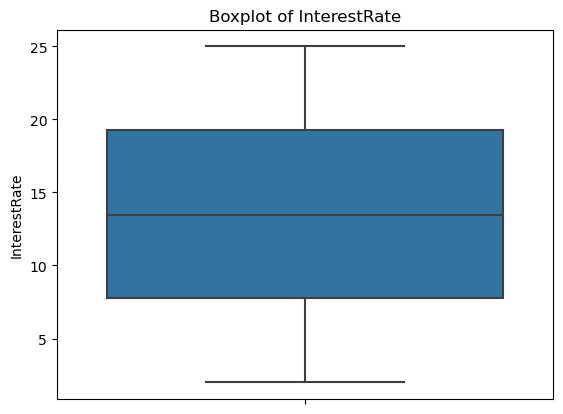

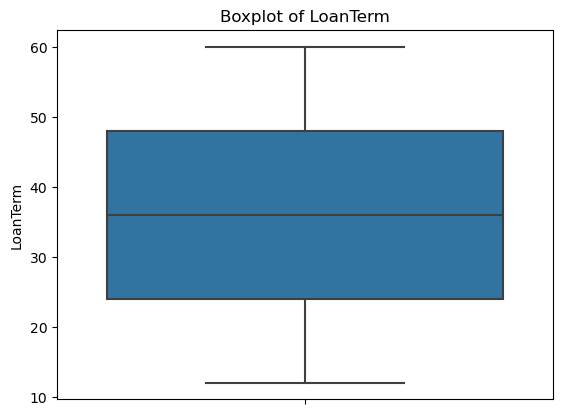

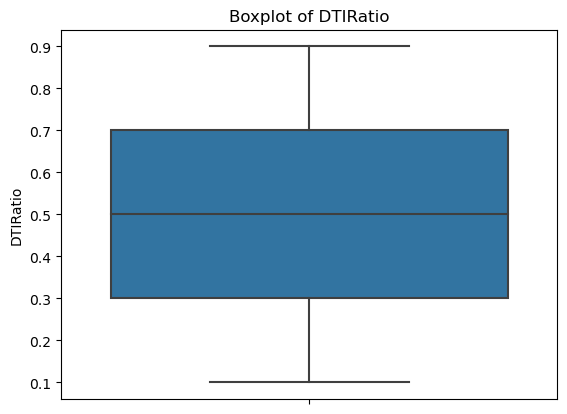

In [23]:
# create another list of numeric columns where we exclude the binary categorical encoded columns because it doesn't make sense to do a box plot on data that can only take values of 0 and 1 but rather on continious data
numeric_columns_2 = ["Age", "Income", "LoanAmount", "CreditScore", "MonthsEmployed", "NumCreditLines", "InterestRate", "LoanTerm", "DTIRatio"]

# iterate through the numeric columns and draw a box plot for each variable to check for outliers
for col in numeric_columns_2:
    sns.boxplot(y=col,data=df_pd)
    plt.title(f'Boxplot of {col}')
    plt.show()

From the box plots above we see that no variable has outliers since there is no point that would lie outside the whiskers. 

## (ii) Applying statistical methods

#### Univariate analysis

In [24]:
# create another list of numerical columns where you include the columns from the first list plus the target varaible "Default"
numeric_columns_3 = numeric_columns + ["Default"]

df.select(numeric_columns_3).describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+
|summary|               Age|           Income|        LoanAmount|       CreditScore|    MonthsEmployed|    NumCreditLines|      InterestRate|          LoanTerm|           DTIRatio|       HasMortgage|     HasDependents|       HasCoSigner|            Default|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+
|  count|            255347|           255347|            255347|            255347|            255347|            255347|            255347|            255347|             255347|            255347|            255347|        

The table above provides some insights into the data related to descriptive statistics. We can see the mean, standard deviation and the range of values in the numerical columns. We didn't include OneHotEncoded columns because it doesn't make sense to use the describe function on them since it would't provide any useful insights. 

We can compare how dispered are variables. For instance, Age has much smaller standard deviation than income which is also supported if we look at the range of values in these two columns. We can draw similar insights about other variables and compare them with each other.

Next, we can check the frequency distributions for categorical columns.

In [25]:
# check the frequency distributions
for col in categorical_columns:
    print(df.groupBy(col).count().show())

+-----------+-----+
|  Education|count|
+-----------+-----+
|High School|63903|
|        PhD|63537|
| Bachelor's|64366|
|   Master's|63541|
+-----------+-----+

None
+--------------+-----+
|EmploymentType|count|
+--------------+-----+
|     Part-time|64161|
| Self-employed|63706|
|     Full-time|63656|
|    Unemployed|63824|
+--------------+-----+

None
+-------------+-----+
|MaritalStatus|count|
+-------------+-----+
|      Married|85302|
|     Divorced|85033|
|       Single|85012|
+-------------+-----+

None
+-----------+-----+
|LoanPurpose|count|
+-----------+-----+
|  Education|51005|
|       Home|51286|
|      Other|50914|
|       Auto|50844|
|   Business|51298|
+-----------+-----+

None


We can see that the distribution accross different classess for each categorical column with more than two classes is very even and balanced which is an extention of the exploration we did in the previous step. Overall, the counts across these categorical variables appear to be relatively balanced, with no significant over-representation or under-representation of any particular category. This is generally desirable when building machine learning models, as imbalanced data can introduce biases and affect the model's performance. This also goes in hand with the insights we got when grouping data and comparing default rate across different groups. We also didn't notice any singnificant over or under-representation.

#### Bivariate analysis

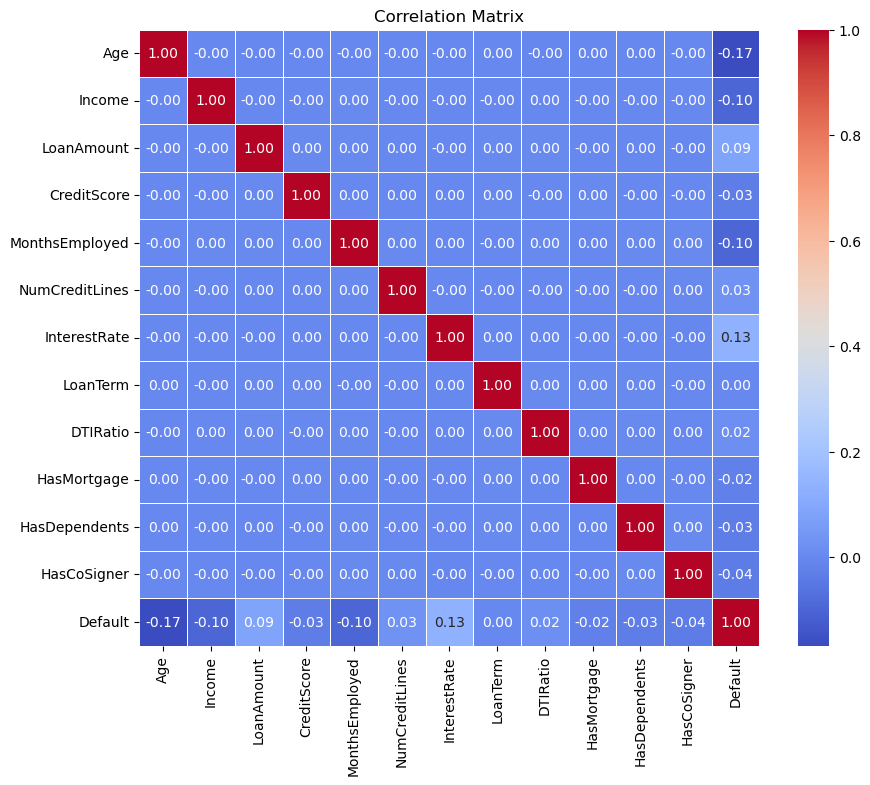

In [26]:
correlation_matrix = df_pd[numeric_columns_3].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

We can display a correlation matrix to check for collinearity between variables and between the variables and the target variable which is "Default" and will be used later in the machine learning stage. The "fmt" parameters indicates that the numbers should be formatted as floating-point numbers with two decimal places. Without passing that parameter, the correlation values between all variables were actually less than 0.00, that's why there are many correlations equal to 0 on the matrix. This indicates that there is no collinearity at all which is an ideal scenario and could imply that this dataset was adjusted to be more suitable for machine learning and other analysis.

Furthermore, we can see that almost all variables have some correlation with the target varaible "Default" but no correlation is above 0.2 which is very low. This could be due to the fact that the "Default" variable is binary so let's try to calculate point-biserial correlation, which is specifically designed to capture the relationship between a continuous variable and a binary variable.

In [27]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr

# function to calculate point-biserial correlation
def point_biserial_corr(df, continuous_var, binary_var):
    continuous_vals = df[continuous_var]
    binary_vals = df[binary_var]
    binary_vals = binary_vals.astype('bool')
    return pointbiserialr(continuous_vals, binary_vals)

# calculate correlations
correlations = []
for col in numeric_columns_3:
    if col != 'Default':
        point_biserial = point_biserial_corr(df_pd, col, 'Default')
        correlations.append({
            'Variable': col,
            'Point-Biserial Correlation': point_biserial[0]
        })

# create a dataframe from the correlations
corr_df = pd.DataFrame(correlations)

# display the correlations
print(corr_df)

          Variable  Point-Biserial Correlation
0              Age                   -0.167783
1           Income                   -0.099119
2       LoanAmount                    0.086659
3      CreditScore                   -0.034166
4   MonthsEmployed                   -0.097374
5   NumCreditLines                    0.028330
6     InterestRate                    0.131273
7         LoanTerm                    0.000545
8         DTIRatio                    0.019236
9      HasMortgage                   -0.022856
10   HasDependents                   -0.034678
11     HasCoSigner                   -0.039109


From the results above, we can see that the correlation values did not improve noticeably so perhaps the correlation values are just not that high.

## (iii) Predicting the default rate
The categorical variable that we will use to develop machine learning models for binary classification is the Default variable which takes the values of 1 (defaulting) and 0 (not defaulting).

In [28]:
df.show(5)

+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+-----------+-------+--------------+-----------------+-------------------+----------------------+------------------+---------------------+----------------+-------------------+--------------------+
|    LoanID|Age|Income|LoanAmount|CreditScore|MonthsEmployed|NumCreditLines|InterestRate|LoanTerm|DTIRatio|  Education|EmploymentType|MaritalStatus|HasMortgage|HasDependents|LoanPurpose|HasCoSigner|Default|EducationIndex|EducationclassVec|EmploymentTypeIndex|EmploymentTypeclassVec|MaritalStatusIndex|MaritalStatusclassVec|LoanPurposeIndex|LoanPurposeclassVec|            features|
+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+-----------+-------+--------------+---------------

If we check the dataset again we see that all the categorical columns are encoded and that there is a features column that we will use in the following steps.

### Scaling the features

In [29]:
from pyspark.ml.feature import StandardScaler

# create model scaler for normalization
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# withStd=True: Scales the data to unit standard deviation
# withMean=False: Does not center the data by subtracting the mean

If the dataset is large and sparse, setting withMean=False is typically preferred to avoid converting sparse data to dense format, which can lead to significant memory overhead.

In [30]:
scalerModel = scaler.fit(df)

In [31]:
scaled_df = scalerModel.transform(df)

In [32]:
scaled_df.show(5)

+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+-----------+-------+--------------+-----------------+-------------------+----------------------+------------------+---------------------+----------------+-------------------+--------------------+--------------------+
|    LoanID|Age|Income|LoanAmount|CreditScore|MonthsEmployed|NumCreditLines|InterestRate|LoanTerm|DTIRatio|  Education|EmploymentType|MaritalStatus|HasMortgage|HasDependents|LoanPurpose|HasCoSigner|Default|EducationIndex|EducationclassVec|EmploymentTypeIndex|EmploymentTypeclassVec|MaritalStatusIndex|MaritalStatusclassVec|LoanPurposeIndex|LoanPurposeclassVec|            features|      scaledFeatures|
+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+--------

### Splitting the data intro training and testing sets

In [33]:
train, test = scaled_df.randomSplit([0.7, 0.3], seed=42)
print(train.count())
print(test.count())

179091


76256


### Logistic regression

In [34]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# initialize the Logistic Regression model
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='Default')

# set up the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()

# set up the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='Default', predictionCol='prediction', metricName='accuracy')

# set up CrossValidator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# train the model using cross-validation
cv_model_lr = crossval.fit(train)

# get the best model
best_model_lr = cv_model_lr.bestModel

# make predictions on the test set using the best model
best_predictions = best_model_lr.transform(test)

# evaluate the best model
best_accuracy_lr = evaluator.evaluate(best_predictions)
print("Best Test Accuracy for Logistic Regression:", best_accuracy_lr)

24/06/01 13:20:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Best Test Accuracy for Logistic Regression: 0.8846779269827948


We get the accuracy of this model to be 88.5 % which is good but maybe can be improved with more sophisticated models.

### Random forests

In [35]:
from pyspark.ml.classification import RandomForestClassifier

# initialize the Random Forest model
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='Default')

# set up the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()

# set up the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='Default', predictionCol='prediction', metricName='accuracy')

# set up CrossValidator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# train the model using cross-validation
cv_model_rf = crossval.fit(train)

# get the best model
best_model_rf = cv_model_rf.bestModel

# make predictions on the test set using the best model
best_predictions_rf = best_model_rf.transform(test)

# evaluate the best model
best_accuracy_rf = evaluator.evaluate(best_predictions_rf)
print("Best Test Accuracy for Random Forest:", best_accuracy_rf)

24/06/01 13:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1652.2 KiB
24/06/01 13:24:19 WARN DAGScheduler: Broadcasting large task binary with size 1635.6 KiB
24/06/01 13:24:28 WARN DAGScheduler: Broadcasting large task binary with size 1176.0 KiB
24/06/01 13:24:29 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/01 13:24:30 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/06/01 13:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1065.4 KiB
24/06/01 13:24:32 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/06/01 13:24:35 WARN DAGScheduler: Broadcasting large task binary with size 1902.9 KiB
24/06/01 13:24:36 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/01 13:24:40 WARN DAGScheduler: Broadcasting large task binary with size 1180.0 KiB
24/06/01 13:24:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/01 13:24:42 WARN DAGScheduler:

Best Test Accuracy for Random Forest: 0.8850451112043642


The accuray of the random forests model is again 88.5% if we round it up, but slightly better if we look a the decimals compared to logistic regression.

### XGBoost

In [36]:
from pyspark.ml.classification import GBTClassifier

# initialize the XGBoost model
xgb = GBTClassifier(featuresCol='scaledFeatures', labelCol='Default')

# set up the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(xgb.maxDepth, [3, 5, 7]) \
    .addGrid(xgb.maxBins, [32, 64]) \
    .addGrid(xgb.maxIter, [10, 50]) \
    .build()

# set up the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='Default', predictionCol='prediction', metricName='accuracy')

# set up CrossValidator
crossval = CrossValidator(estimator=xgb,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# train the model using cross-validation
cv_model_xgb = crossval.fit(train)

# get the best model
best_model_xgb = cv_model_xgb.bestModel

# make predictions on the test set using the best model
best_predictions_xgb = best_model_xgb.transform(test)

# evaluate the best model
best_accuracy_xgb = evaluator.evaluate(best_predictions_xgb)
print("Best Test Accuracy for XGBoost:", best_accuracy_xgb)


24/06/01 13:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1003.4 KiB
24/06/01 13:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1003.9 KiB
24/06/01 13:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB
24/06/01 13:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1005.6 KiB
24/06/01 13:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1007.8 KiB
24/06/01 13:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1012.4 KiB
24/06/01 13:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1021.4 KiB
24/06/01 13:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1026.0 KiB
24/06/01 13:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1026.5 KiB
24/06/01 13:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1027.1 KiB
24/06/01 13:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1028.2 KiB
24/06/01 13:31:16 WAR

Best Test Accuracy for XGBoost: 0.8863040285354595


The accuracy for the XGBoost model did slightly improve from 88.5% to 88.6%. So according to the accuracy, we could say that this is the best model because it makes the most accurate predictions. However, since there is only a slight increase in the accuracy but the complexity of the model and consequently, the computational power is much higher compared to logistic regression, it makes sense to say that rather logistic regression is the best model in this case because its accuracy is almost the same but the complexity is much lower.

It is also worth noting that random forests and XGBoost are very computationally expensive and we needed to cut down on the number of parameters to search for in the grid search cross validation to avoid an error. This could be improved by expanding computational power and adding more computers to the cluster.

# Conclusion
Through this analysis we have explored the Loan Default dataset, ran statistical analysis, and build three machine learning models to classify the target variable Default. We can conclude that the best model was Logistic Regression with accuracy of 88.5%.